In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
plt.rcParams.update({'font.size': 14})
def error(phi_a,phi_n):
    # compute error between analytical and numerical numbers

    return (phi_a-phi_n)/phi_a*100

def convert1D_to_2D(A,N,M):
# Convert phi1D to 2D
    A2D = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            k = (j-1)*N + i
            A2D[i,j]=A[k]

    return A2D

def prepare_phi_and_S(Nx,Ny,phi,L, H, convert_to_K = False):

    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    if convert_to_K:
        S = np.zeros((Nx*Ny))
    else:   
        S = np.zeros((Nx,Ny))
    dx = L/(Nx-1)    # Grid size
    dy = H/(Ny-1)    # Grid size
    # RHS source terms
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy
            
            source = 2 * np.sinh(10 * (x - 0.5)) + 40 * (x - 0.5) * np.cosh(10 * (x - 0.5)) + 100 * (
                    x - 0.5) ** 2 * np.sinh(10 * (x - 0.5)) + 2 * np.sinh(10 * (y - 0.5)) + 40 * (
                            y - 0.5) * np.cosh(10 * (y - 0.5)) + 100 * (y - 0.5) ** 2 * np.sinh(
                10 * (y - 0.5)) + 4 * (x ** 2 + y ** 2) * np.exp(2 * x * y)
            
            if convert_to_K:
                k = (j - 1) * Nx + i
                S[k] = source
            else:
                S[i,j] = source

    
    ## Right BC
    i = Nx-1 
    for j in range(1,Ny-1):

        x = i*dx
        y = j*dy
        phiR = 0.25*np.sinh(5)+(y-0.5)**2*np.sinh(10*(y-0.5))+np.exp(2*y)
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i,j] = phiR
            S[i,j] = phiR
        
    ## left BC
    i = 0
    for j in range(1,Ny-1):
        
        x = i*dx
        y = j*dy
        
        phiL = 0.25*np.sinh(-5) + (y-0.5)**2*np.sinh(10*(y-0.5))+1

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i,j] = phiL
            S[i,j] = phiL 

    ## Bottom BC
    j=0
    for i in range(Nx):
        
        x = i*dx
        y = j*dy
        
        phiB = 0.25*np.sinh(-5) + (x-0.5)**2*np.sinh(10*(x-0.5))+1
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i,j] = phiB
            S[i,j] = phiB
        

    ## Top BC
    j=Ny-1
    for i in range(Nx):
        
        x = i*dx
        y = j*dy
        
        phiT = 0.25*np.sinh(5)+(x-0.5)**2*np.sinh(10*(x-0.5))+np.exp(2*x)
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i,j] = phiT
            S[i,j] = phiT

    return phi, S


def plot_phi(phi,phi_A,Nx,Ny,method_name,convert=False):

    # If need convert phi from phi[K] to phi[i,j], aka, phi1D to phi2D
    if convert:
        # Analytical solution
        phi2D = np.zeros((Nx,Ny))
        # Convert phi1D to 2D
        for i in range(Nx):
            for j in range(Ny):
                k = (j-1)*Nx+ i
                phi2D[i,j]=phi[k]
        phi = phi2D

    # Plot        
    x,y = np.meshgrid(np.linspace(0,1,Nx),np.linspace(0,1,Ny), indexing='ij')
    fig, ax = plt.subplots(figsize=(14,8))
    CS = ax.contour(x,y,phi, levels=np.arange(-30,30,5))
    ax.clabel(CS, inline=True, fontsize=10)
    CB = fig.colorbar(CS)
    ax.set_xlabel('Distance, x')
    ax.set_ylabel('Distance, y')

    ax.set_title('Numerical solution by '+method_name+' iterative solver, code by Congcong Fan')
    fig.tight_layout()

    fig, ax = plt.subplots(figsize=(14,8))
    ax.set_title('Analytical solution, code by Congcong Fan')

    CS = ax.contour(x,y,phi_A, levels=np.arange(-30,30,5))
    ax.clabel(CS, inline=True, fontsize=10)
    CB = fig.colorbar(CS)
    ax.set_xlabel('Distance, x')
    ax.set_ylabel('Distance, y')
    fig.tight_layout()

    # Error
    e = error(phi_A,phi)
    fig, ax = plt.subplots(figsize=(14,8))
    CS = ax.contour(e,levels=np.arange(-0.14,0.14,0.02))
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('Errors, code by Congcong Fan')
    # make a colorbar for the contour lines
    CB = fig.colorbar(CS)
    ax.set_xlabel('Distance, x')
    ax.set_ylabel('Distance, y')
    fig.tight_layout()

def residual(Nx,Ny,phi,S,aE,aW,aN,aS,a0):
    
    R = np.zeros(Nx*Ny)
    R2sum = 0
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):

            k = (j - 1) * Nx + i
            R[k] = S[k] - aE * phi[k + 1] - aW * phi[k - 1] - aN * phi[k + Nx] - aS * phi[k - Nx] - a0 * phi[k]

            R2sum = R2sum + R[k] ** 2
    
    return R2sum, R



# Alternating Direction Implicit (ADI) Line-by-line method, row-wise then column-wise. 
e.g. solve at constant i direction then march in j direction. Then in same loop, solve at constant j then march in i 

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
plt.rcParams.update({'font.size': 14})

from utilities import error, prepare_phi_and_S, convert1D_to_2D, plot_phi,residual

In [39]:
def TRI(N,a,d,c,Q):
    '''
    ┌                                        ┐
    │  d1  c1  0 ...                        0│
    │  a1  d2  c2  0 ...                    0│
    │           .                            │
    │                .                       │
    │                    .                   │┌     ┐  ┌     ┐
    │...         0   ai-2  di-1  ci-1 0  ... ││Phi_x│= | Q_x |
    │                          .             │└     ┘  └     ┘
    │                            .           │
    │                               .        │
    │0     ... 0              aN-2  dN-1 cN-1│
    │0                       ... 0   aN-1  dN│ 
    └                                        ┘
    '''
    # Tridiagonal matrix solver
    phi = np.zeros(N)

    # Forward Elemination
    for i in range (1,N):
        const = a[i-1] / d[i-1]
        d[i] = d[i] - const*c[i-1] # Diagonal
        Q[i] = Q[i] - const*Q[i-1]  # RHS
    
    # Solve last equation 
    phi[-1] = Q[-1]/d[-1]

    # Backward Elemination
    for i in range(N-2,-1,-1):
        
        phi[i] = (Q[i] - c[i]*phi[i+1]) / d[i]

    return phi

<img src="Q/ex3.2.png">
<img src="Q/ex3.2.1.png">


<div class="alert alert-block alert-info">
For a TDMA

</div>
<img src="Q/ex3.2.3.png">

In [46]:

# numbering scheme used is k = (j-1)*N + i
start = time.time()
Nx = 41
Ny = 41
L, H = 1, 1   # Computational domain 
phi = np.zeros((Nx,Ny))
S = np.zeros((Nx,Ny))

dx = L/(Nx-1)    # Grid size
dy = H/(Ny-1)    # Grid size

tol = 1e-6



phi, S = prepare_phi_and_S(Nx, Ny, phi, L, H)

high_acc = True
R_TRI_logger = []
for _ in tqdm(range(100000)):
    '''
    [A] [Phi]= [Q]
    d, a, c are diagonal terms for TDMA solver
    For row-wise sweep, the TDMA will take current j-th row in [A], then assemble the coefficients.
    Since start with 2nd row, the BCs for LHS and RHS is always 'felt' by TDMA. Thus, d[0]=1, Q_x[0]=Phi_left, d[Nx-1]=1. Q_x[Nx-1]=Phi_right
    The every row, solve the matrix showed below. And update new Phi for that j-th row. Phi[:,j] = Phi_x
    ┌                                        ┐
    │  d1  c1  0 ...                        0│
    │  a1  d2  c2  0 ...                    0│
    │           .                            │
    │                .                       │
    │                    .                   │┌     ┐  ┌     ┐
    │...         0   ai-2  di-1  ci-1 0  ... ││Phi_x│= | Q_x |
    │                          .             │└     ┘  └     ┘
    │                            .           │
    │                               .        │
    │0     ... 0              aN-2  dN-1 cN-1│
    │0                       ... 0   aN-1  dN│ 
    └                                        ┘
    '''

    # Row-wise sweep
    # Start with initialize the coefficients for TDMA
    c = np.zeros(Nx-1)
    a = np.zeros(Nx-1)
    d = np.zeros(Nx)
    Q_x = np.zeros(Nx)
    for j in range(1,Ny-1):

        # For Dirichlet BC
        d[0] = 1

        # Left BC
        Q_x[0] = phi[0,j]

        for i in range(1,Nx-1):
            
            # If need 4th-order acc
            if high_acc:

                # Since higher order approximation is special at one node after BC, as shown below with square dot.
                # The pratical way to deal with that inner node is back to 2nd order approximation as before
                '''
                ┌                                  ┐
                │ . .  .  .  .  .  .  .  .  .  .  .│
                │ . ■  ■  ■  ■  ■  ■  ■  ■  ■  ■  .│
                │ . ■                          ■  .│
                │ . ■                          ■  .│
                │ . ■                          ■  .│
                │ . ■                          ■  .│
                │ . ■                          ■  .│    
                │ . ■  ■  ■  ■  ■  ■  ■  ■  ■  ■  .│
                │ . .  .  .  .  .  .  .  .  .  .  .│
                └                                  ┘
                '''

                # If at one node after BC node
                if i==1 or i==Nx-2 or j==1 or j==Ny-2:
                    
                    # TDMA Coefficients
                    d[i] = -(2/dx**2 + 2/dy**2)
                    a[i-1] = 1/dx**2
                    c[i] = 1/dx**2
                    
                    # RHS for TDMA matrix
                    Q_x[i] = S[i,j] - phi[i,j+1]*(1/dy**2) - phi[i,j-1]*(1/dy**2)
                
                else:
                    # TDMA Coefficients with higher order approximation
                    d[i] = -(5/ (2*dx**2) + 5/ (2*dy**2))
                    a[i-1] = 4/(3*dx**2)
                    c[i] = 4/(3*dx**2)

                    # RHS for TDMA matrix with higher order approximation
                    Q_x[i] = S[i,j] + ((phi[i,j+2] - 4*phi[i,j+1] - 4*phi[i,j-1] + phi[i,j-2])) / (12*dy**2) - (phi[i,j+1] + phi[i,j-1])/dy**2 + (phi[i+2,j] + phi[i-2,j])/(12*dx**2)
            
            # Normal 2nd order acc
            else:
                d[i] = -(2/dx**2 + 2/dy**2)
                a[i-1] = 1/dx**2
                c[i] = 1/dx**2
                
                # RHS for Tri matrix
                Q_x[i] = S[i,j] - phi[i,j+1]*(1/dx**2) - phi[i,j-1]*(1/dx**2)

        # For Dirichlet BC
        d[Nx-1]=1
        
        # Right BC
        Q_x[Nx-1] = phi[-1,j]
        
        # Solve for current row
        phix = TRI(Nx,a,d,c,Q_x)

        # Update current new row solution
        phi[:,j] = phix

    
    # Column-wise sweep
    c = np.zeros(Ny-1)
    a = np.zeros(Ny-1)
    d = np.zeros(Ny)
    Q_y = np.zeros(Ny)

    for i in range(1,Nx-1):

        # For Dirichlet BC
        d[0] = 1

        # Bottom BC
        Q_y[0] = phi[i,0]

        for j in range(1,Ny-1):
            x = i*dx
            y = j*dy
            # Coefficient for Tridiagonal matrix solver
            if high_acc:
                if i==1 or i==Nx-2 or j==1 or j==Ny-2:

                    # Coefficient for Tridiagonal matrix solver
                    d[j] = -(2/dx**2 + 2/dy**2)
                    a[j-1] = 1/dy**2
                    c[j] = 1/dy**2

                    # RHS for Tri matrix
                    Q_y[j] = S[i,j] - phi[i+1,j]*(1/dx**2) - phi[i-1,j]*(1/dx**2)
            
                else:
                    d[j] = -(5/ (2*dx**2) + 5/ (2*dy**2))
                    a[j-1] = 4/(3*dy**2)
                    c[j] = 4/(3*dy**2)

                    # RHS for Tri matrix
                    Q_y[j] = S[i,j] + ((phi[i+2,j] - 4*phi[i+1,j] - 4*phi[i-1,j] + phi[i-2,j])) / (12*dx**2) - (phi[i+1,j] + phi[i-1,j])/dx**2 + (phi[i,j+2] + phi[i,j-2])/(12*dy**2)
            
            else:
                # Coefficient for Tridiagonal matrix solver
                    d[j] = -(2/dx**2 + 2/dy**2)
                    a[j-1] = 1/dy**2
                    c[j] = 1/dy**2

                    # RHS for Tri matrix
                    Q_y[j] = S[i,j] - phi[i+1,j]*(1/dx**2) - phi[i-1,j]*(1/dx**2)
        # For Dirichlet BC
        d[Ny-1]=1
        
        # Top BC
        Q_y[Ny-1] = phi[i,Ny-1]
        
        # Solve for current row
        phix = TRI(Ny,a,d,c,Q_y)

        # Update current new row solution
        phi[i,:] = phix


    # Calculate residual 
    R2 = 0
    R = np.zeros((Nx,Ny))
    
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            if high_acc:
                if i==1 or i==Nx-2 or j==1 or j==Ny-2:
                    aE = 1/dx**2
                    aW = 1/dx**2
                    aN = 1/dy**2
                    aS = 1/dy**2
                    a0 = -(2/dx**2 + 2/dy**2)
                    R[i,j] = S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1] - a0*phi[i,j]
                    R2 = R2+R[i,j]**2
                
                else:
                    # aE = 4/(3*dx**2)
                    # aEE = 1/(12*dx**2)
                    
                    # aW = 4/(3*dx**2)
                    # aWW = 1/(12*dx**2)
                    
                    # aN = -4/(12*dy**2) - 1/dy**2
                    # aNN = 1/(12*dy**2)

                    # aS = -4/(12*dy**2) - 1/dy**2
                    # aSS = 1/(12*dy**2)

                    a0 = -(5/(2*dx**2) + 5/(2*dy**2))
                    R[i,j] = S[i,j] +(1/(12*dy**2))*(phi[i,j+2] - 4*phi[i,j+1]-4*phi[i,j-1]+phi[i,j-2]) - (phi[i,j+1] + phi[i,j-1])/dy**2 + (phi[i+2,j] + phi[i-2,j])/(12*dx**2) - a0*phi[i,j] - 4/(3*dx**2)*phi[i+1,j]- 4/(3*dx**2)*phi[i-1,j]
                    R2 = R2+R[i,j]**2
                
            else:
                aE = 1/dx**2
                aW = 1/dx**2
                aN = 1/dy**2
                aS = 1/dy**2
                a0 = -(2/dx**2 + 2/dy**2)
                R[i,j] = S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1] - a0*phi[i,j]
                R2 = R2+R[i,j]**2
    R2 = np.sqrt(R2)
    R_TRI_logger.append(R2)
    if _ %100==0:
        clear_output(True)
        print("Residual: ",R2)
        
    if R2<tol:
        print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
        break



  1%|          | 905/100000 [00:29<54:50, 30.12it/s]

Residual:  1.9480871952842014e-06


  1%|          | 930/100000 [00:30<54:27, 30.32it/s]

Converged! Residual:  9.878010624517914e-07 Time elapsed:  30.69036293029785


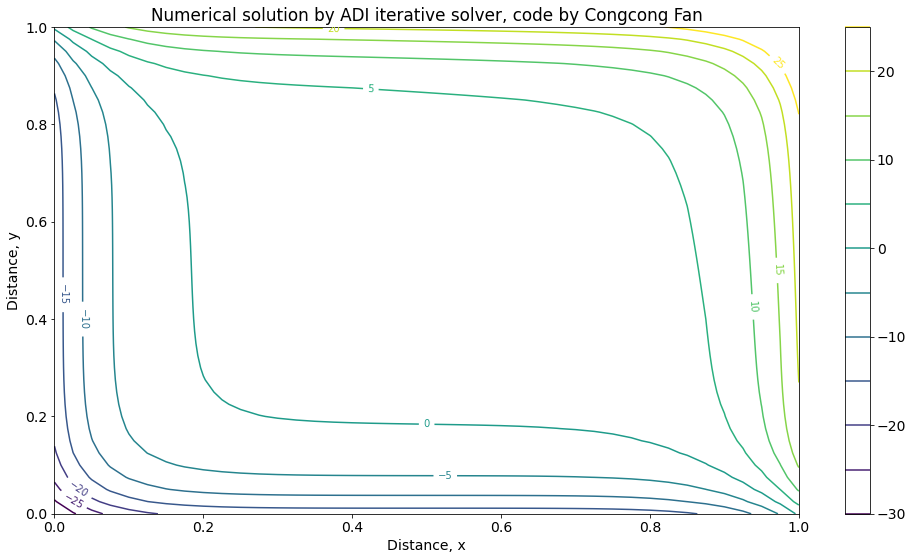

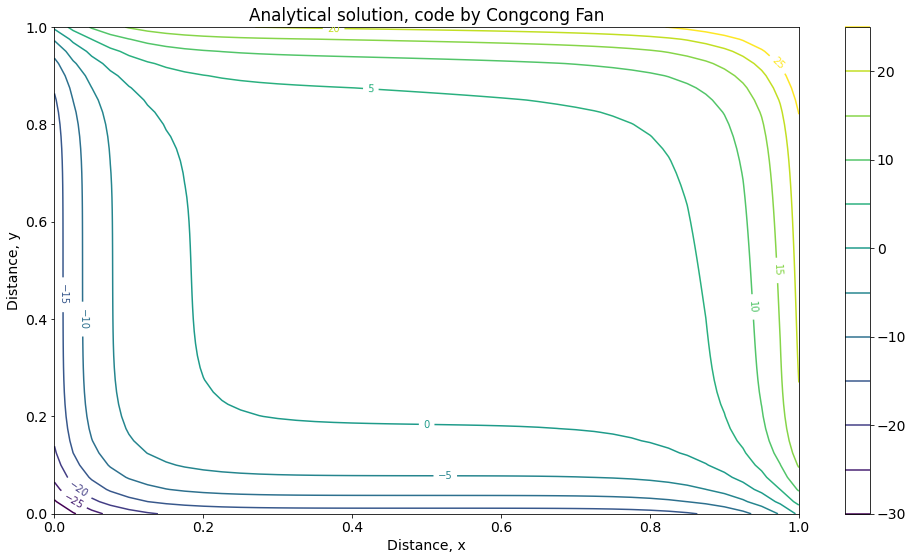

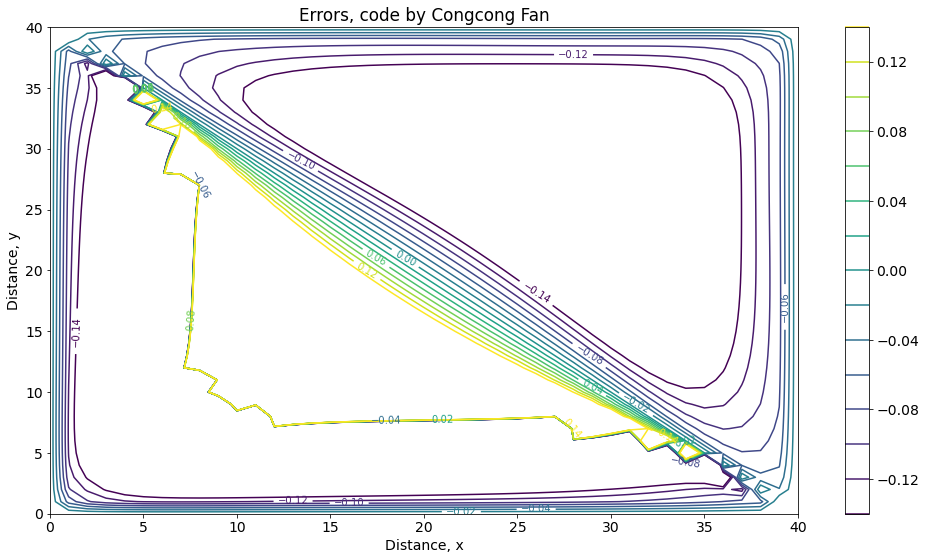

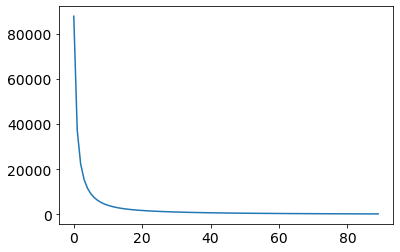

In [48]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi, phi_A, Nx, Ny, 'ADI', convert=False)

plt.figure()
plt.plot(R_TRI_logger[:90])




<div class="alert alert-block alert-info">
For a PDMA

</div>
<img src="Q/ex3.2.4.png">

In [ ]:
def PEN(N, e, a, d, c, f,Q):
    '''
    ┌                                        ┐
    │  d1  c1  f1 ...                       0│
    │  a1  d2  c2  f2 ...                   0│
    │  e1         .                          │
    │                .                       │
    │                    .                   │┌     ┐  ┌     ┐
    │...         ei-2   ai-1  di  ci fi  ... ││Phi_x│= | Q_x |
    │                          .             │└     ┘  └     ┘
    │                            .           │
    │                               .    fN-2│
    │0     ... 0              aN-2  dN-1 cN-1│
    │0                    ... eN-2   aN-1  dN│ 
    └                                        ┘
    '''
    # Tridiagonal matrix solver
    phi = np.zeros(N)

    # Forward Elemination
    for i in range (3,N-1):
        const1 = a[i-1] / d[i-1]
        d[i] = d[i] - const1 * c[i-1] 
        c[i] = c[i] - const1 * f[i-1]
        Q[i] = Q[i] - const1 * Q[i-1]  

        const2 = e[i-1]/d[i-1]
        a[i] = a[i] - const2*c[i-1]
        d[i+1] = d[i+1] - const2 * f[i-1]
        Q[i+1] = Q[i+1] - const2 * d[i-1]
    # Solve last equation 
    const3 = a[N-2] / d[N-2]
    d[N-1] = d[N-1] - const3 * c[N-2]
    phi[N-1] = (Q[N-1] - const3 * Q[N-2]) / d[N-1]
    phi[N-2] = [Q[N-2] - c[N-2] * Q[N-1]] / d[N-2]

    # Backward Elemination
    for i in range(N-3,-1,-1):
        
        phi[i] = (Q[i] - c[i]*phi[i+1] - f[i] * phi[i+2]) / d[i]

    return phi

In [ ]:

# numbering scheme used is k = (j-1)*N + i
start = time.time()
Nx = 41
Ny = 41
L, H = 1, 1   # Computational domain 
phi = np.zeros((Nx,Ny))
S = np.zeros((Nx,Ny))

dx = L/(Nx-1)    # Grid size
dy = H/(Ny-1)    # Grid size

tol = 1e-6



phi, S = prepare_phi_and_S(Nx, Ny, phi, L, H)

high_acc = True
for _ in tqdm(range(100000)):
    '''
    [A] [Phi]= [Q]
    d, a, c are diagonal terms for PDMA solver
    For row-wise sweep, the PDMA will take current j-th row in [A], then assemble the coefficients.
    Since start with 2nd row, the BCs for LHS and RHS is always 'felt' by PDMA. Thus, d[0]=1, Q_x[0]=Phi_left, d[Nx-1]=1. Q_x[Nx-1]=Phi_right
    The every row, solve the matrix showed below. And update new Phi for that j-th row. Phi[:,j] = Phi_x
    ┌                                        ┐
    │  d1  c1  0 ...                        0│
    │  a1  d2  c2  0 ...                    0│
    │           .                            │
    │                .                       │
    │                    .                   │┌     ┐  ┌     ┐
    │...         0   ai-2  di-1  ci-1 0  ... ││Phi_x│= | Q_x |
    │                          .             │└     ┘  └     ┘
    │                            .           │
    │                               .        │
    │0     ... 0              aN-2  dN-1 cN-1│
    │0                       ... 0   aN-1  dN│ 
    └                                        ┘
    '''

    # Row-wise sweep
    # Start with initialize the coefficients for PDMA
    c = np.zeros(Nx-1)
    a = np.zeros(Nx-1)
    f = np.zeros(Nx-2)
    e = np.zeros(Nx-2)
    d = np.zeros(Nx)
    Q_x = np.zeros(Nx)
    for j in range(1,Ny-1):

        # For Dirichlet BC
        d[0] = 1

        # Left BC
        Q_x[0] = phi[0,j]

        for i in range(1,Nx-1):
            
            # If need 4th-order acc
            if high_acc:

                # Since higher order approximation is special at one node after BC, as shown below with square dot.
                # The pratical way to deal with that inner node is back to 2nd order approximation as before
                '''
                ┌                                  ┐
                │ . .  .  .  .  .  .  .  .  .  .  .│
                │ . ■  ■  ■  ■  ■  ■  ■  ■  ■  ■  .│
                │ . ■                          ■  .│
                │ . ■                          ■  .│
                │ . ■                          ■  .│
                │ . ■                          ■  .│
                │ . ■                          ■  .│    
                │ . ■  ■  ■  ■  ■  ■  ■  ■  ■  ■  .│
                │ . .  .  .  .  .  .  .  .  .  .  .│
                └                                  ┘
                '''

                # If at one node after BC node
                if i==1 or i==Nx-2 or j==1 or j==Ny-2:
                    
                    # PDMA Coefficients
                    d[i] = -(2/dx**2 + 2/dy**2)
                    a[i-1] = 1/dx**2
                    c[i] = 1/dx**2
                    
                    # RHS for PDMA matrix
                    Q_x[i] = S[i,j] - phi[i,j+1]*(1/dy**2) - phi[i,j-1]*(1/dy**2)
                
                else:
                    # PDMA Coefficients with higher order approximation
                    d[i] = -(5/ (2*dx**2) + 5/ (2*dy**2))
                    a[i-1] = 4/(3*dx**2)
                    c[i] = 4/(3*dx**2)
                    f[i] = -1/(12*dx**2)
                    e[i-2] = -1/(12*dx**2)
                    # RHS for PDMA matrix with higher order approximation
                    Q_x[i] = S[i,j] + ((phi[i,j+2] - 4*phi[i,j+1] - 4*phi[i,j-1] + phi[i,j-2])) / (12*dy**2) - (phi[i,j+1] + phi[i,j-1])/dy**2
            
            # Normal 2nd order acc
            else:
                d[i] = -(2/dx**2 + 2/dy**2)
                a[i-1] = 1/dx**2
                c[i] = 1/dx**2
                
                # RHS for Tri matrix
                Q_x[i] = S[i,j] - phi[i,j+1]*(1/dx**2) - phi[i,j-1]*(1/dx**2)

        # For Dirichlet BC
        d[Nx-1]=1
        
        # Right BC
        Q_x[Nx-1] = phi[-1,j]
        
        # Solve for current row
        phix = PEN(Nx, e, a, d, c, f,Q_x)

        # Update current new row solution
        phi[:,j] = phix

    
    # # Column-wise sweep
    # c = np.zeros(Ny-1)
    # a = np.zeros(Ny-1)
    # d = np.zeros(Ny)
    # Q_y = np.zeros(Ny)

    # for i in range(1,Nx-1):

    #     # For Dirichlet BC
    #     d[0] = 1

    #     # Bottom BC
    #     Q_y[0] = phi[i,0]

    #     for j in range(1,Ny-1):
    #         x = i*dx
    #         y = j*dy
    #         # Coefficient for Tridiagonal matrix solver
    #         if high_acc:
    #             if i==1 or i==Nx-2 or j==1 or j==Ny-2:

    #                 # Coefficient for Tridiagonal matrix solver
    #                 d[j] = -(2/dx**2 + 2/dy**2)
    #                 a[j-1] = 1/dy**2
    #                 c[j] = 1/dy**2

    #                 # RHS for Tri matrix
    #                 Q_y[j] = S[i,j] - phi[i+1,j]*(1/dx**2) - phi[i-1,j]*(1/dx**2)
            
    #             else:
    #                 d[j] = -(5/ (2*dx**2) + 5/ (2*dy**2))
    #                 a[j-1] = 4/(3*dy**2)
    #                 c[j] = 4/(3*dy**2)

    #                 # RHS for Tri matrix
    #                 Q_y[j] = S[i,j] + ((phi[i+2,j] - 4*phi[i+1,j] - 4*phi[i-1,j] + phi[i-2,j])) / (12*dx**2) - (phi[i+1,j] + phi[i-1,j])/dx**2 + (phi[i,j+2] + phi[i,j-2])/(12*dy**2)
            
    #         else:
    #             # Coefficient for Tridiagonal matrix solver
    #                 d[j] = -(2/dx**2 + 2/dy**2)
    #                 a[j-1] = 1/dy**2
    #                 c[j] = 1/dy**2

    #                 # RHS for Tri matrix
    #                 Q_y[j] = S[i,j] - phi[i+1,j]*(1/dx**2) - phi[i-1,j]*(1/dx**2)
    #     # For Dirichlet BC
    #     d[Ny-1]=1
        
    #     # Top BC
    #     Q_y[Ny-1] = phi[i,Ny-1]
        
    #     # Solve for current row
    #     phix = TRI(Ny,a,d,c,Q_y)

    #     # Update current new row solution
    #     phi[i,:] = phix


    # Calculate residual 
    R2 = 0
    R = np.zeros((Nx,Ny))
    R_TRI_logger = []
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            if high_acc:
                if i==1 or i==Nx-2 or j==1 or j==Ny-2:
                    aE = 1/dx**2
                    aW = 1/dx**2
                    aN = 1/dy**2
                    aS = 1/dy**2
                    a0 = -(2/dx**2 + 2/dy**2)
                    R[i,j] = S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1] - a0*phi[i,j]
                    R2 = R2+R[i,j]**2
                
                else:
                    # aE = 4/(3*dx**2)
                    # aEE = 1/(12*dx**2)
                    
                    # aW = 4/(3*dx**2)
                    # aWW = 1/(12*dx**2)
                    
                    # aN = -4/(12*dy**2) - 1/dy**2
                    # aNN = 1/(12*dy**2)

                    # aS = -4/(12*dy**2) - 1/dy**2
                    # aSS = 1/(12*dy**2)

                    a0 = -(5/(2*dx**2) + 5/(2*dy**2))
                    R[i,j] = S[i,j] +(1/(12*dy**2))*(phi[i,j+2] - 4*phi[i,j+1]-4*phi[i,j-1]+phi[i,j-2]) - (phi[i,j+1] + phi[i,j-1])/dy**2 + (phi[i+2,j] + phi[i-2,j])/(12*dx**2) - a0*phi[i,j] - 4/(3*dx**2)*phi[i+1,j]- 4/(3*dx**2)*phi[i-1,j]
                    R2 = R2+R[i,j]**2
                
            else:
                aE = 1/dx**2
                aW = 1/dx**2
                aN = 1/dy**2
                aS = 1/dy**2
                a0 = -(2/dx**2 + 2/dy**2)
                R[i,j] = S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1] - a0*phi[i,j]
                R2 = R2+R[i,j]**2
    R2 = np.sqrt(R2)
    R_TRI_logger.append(R2)
    if _ %50==0:
        clear_output(True)
        print("Residual: ",R2)
        
    if R2<tol:
        print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
        break



  0%|          | 210/100000 [00:05<40:55, 40.64it/s]

Residual:  605792.4646118081


  0%|          | 225/100000 [00:05<41:49, 39.75it/s]


KeyboardInterrupt: 

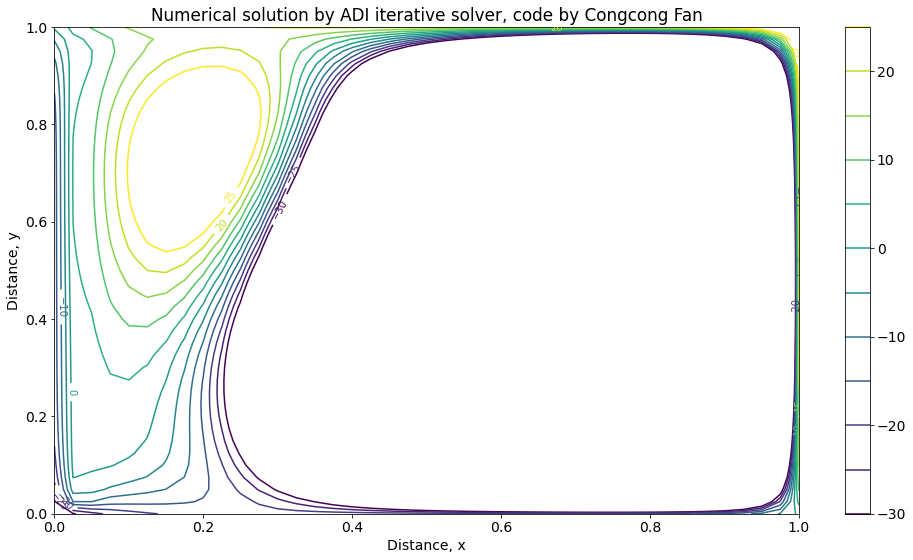

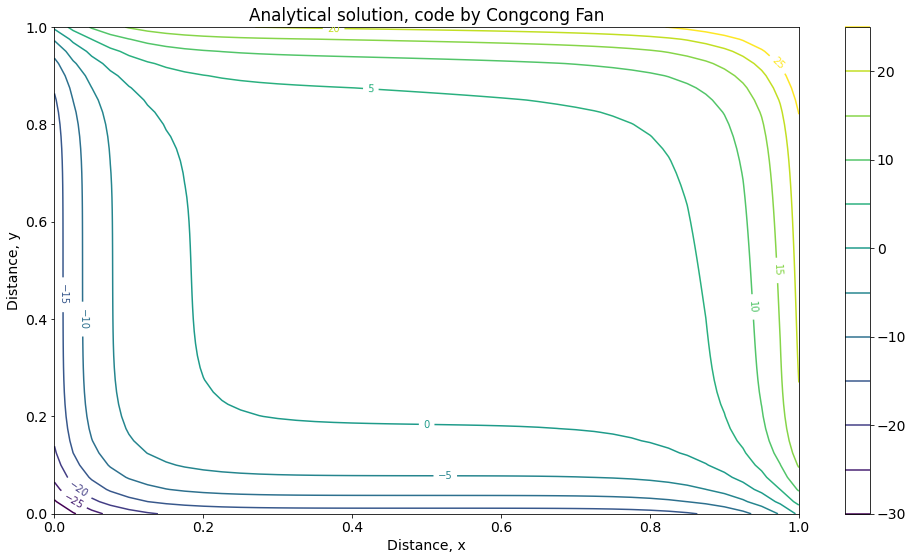

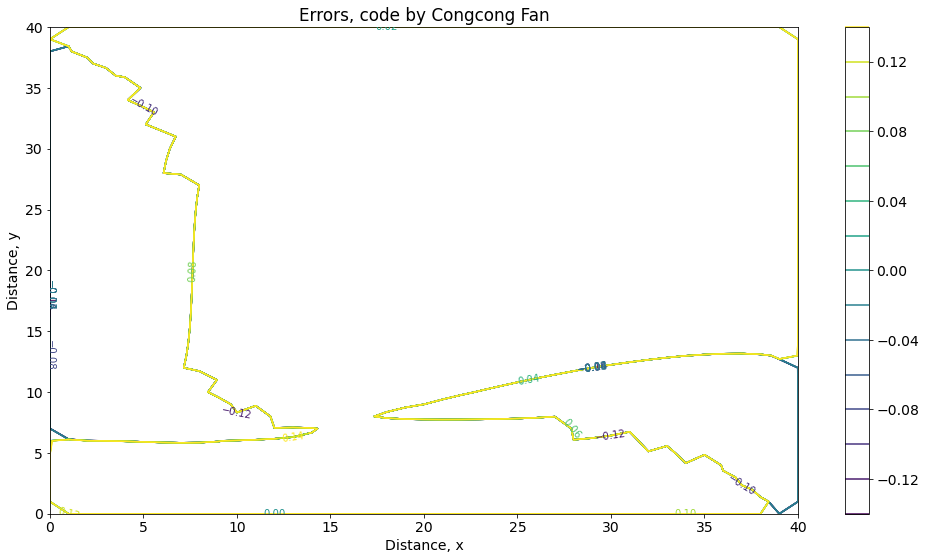

In [ ]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi, phi_A, Nx, Ny, 'ADI', convert=False)




